# Sentiment Analysis witn an RNN
In this notebook, you'll implement a recurrent neural network that performs sentiment analysis.

> Using an RNN rather than a strictly feedforward network is more acurate since we can include information about the sequence of words.

Here we'll use a dataset of tweets, accompanied by sentiment labels: positive or negative

<img src="assets/img1.png" width=40%>

## Network Architecture
The architecture for this network is shown below

<img src="assets/img2.png" width=60%>

> **First we'll pass in words to an embedding layer.** We need an embedding layer because we have tens of thousands of words, so we'll need a more efficient representation for our inout data than one-hot encoded vectors. You can actually train an embedding with the Skip-gram Word2Vec model and use those embeddings as input, here. However, it's good enough to just have an embedding layer and let the network learn a different embedding table on its own. _In this case, the embedding layer is for dimensionality reduction, rather than for learning semantic representation._

> **After Input words are passed to an embedding layer, the new embeddings will be passed to LSTM cells.** The LSTM cells will add _recurrent_ connections to the network and give us the ability to include information about the sequence of words in the tweets data.

> **Finally, the LSTM outputs will go to a sigmoid output layer.** We're using a sigmoid function because positive and negative = 1 and 0, respectively, and sigmoid will output predicted, sentiment values between 0-1

We don't care about sigmoid outputs except for the **very last one** we can ignore the rest. We'll calculate the loss by comparing the output at the last time step and the training label (pos or neg)

## Load in and visualize the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# read data
# TO-DO fill the filename with your file path 
filename = "beras_or_miskin.csv"
df = pd.read_csv(filename, encoding="ISO-8859-1")
df.head()

,hashtags,username,tweet_id,tweet_url,timestamp,text,text_html,links,label
0,[],Des B,1.100000e+18,/descanto/status/1098177427241607168,2/20/19 11:07,Cinta itu adalah jiwa. Antara cinta sejati ...,"<p class=""TweetTextSize js-tweet-text tweet-te...",['https://www.instagram.com/p/BuGfDr1FKJn/?utm...,0
1,[],yeni susanti,1.100000e+18,/yenysusanty/status/1097091130422890497,2/17/19 11:11,Selalu salut sama @emakblogersolo yg gak henti...,"<p class=""TweetTextSize js-tweet-text tweet-te...",['https://www.instagram.com/p/Bt-xJLygYbh/?utm...,0
2,[],latifah kusuma,1.100000e+18,/latifahkusuma7/status/1095150154439483392,2/12/19 02:38,Ternyata film_okb Mengandung Kisah Nyata Penul...,"<p class=""TweetTextSize js-tweet-text tweet-te...",['https://www.instagram.com/p/Btw-fVygrMc/?utm...,0
3,"['_Ù__ä_ç___ç_____µ__µ__Ù', 'yogyakarta...",Imam Munandar,1.090000e+18,/nandar_euy/status/1094458868522934272,2/10/19 04:51,Boleh Miskin Asal Bahagia. \rAsal tau aja cara...,"<p class=""TweetTextSize js-tweet-text tweet-te...",['https://www.instagram.com/p/BtsEIXsFzI1/?utm...,0
4,"['dolanindie', 'sisijogja', 'infojogja', 'expl...",Mas Titis Waelah,1.090000e+18,/maz_Titiz/status/1094396002167996418,2/10/19 00:41,"Janganlah engkau MENGARUNGI LAUTAN, percuma de...","<p class=""TweetTextSize js-tweet-text tweet-te...",['https://www.instagram.com/p/Btrnis6lGF9/?utm...,0


First, we drop the columns that we don't need for specific purpose of sentiment analysis

In [2]:
df.drop(['hashtags', 'username', 'tweet_id', 'tweet_url', 'timestamp', 'text_html','links'], axis =1, inplace=True)

Drop duplicates row

In [3]:
df = pd.DataFrame.drop_duplicates(df)

In [4]:
print(df.shape)
df.head()

(3207, 2)


,text,label
0,Cinta itu adalah jiwa. Antara cinta sejati ...,0
1,Selalu salut sama @emakblogersolo yg gak henti...,0
2,Ternyata film_okb Mengandung Kisah Nyata Penul...,0
3,Boleh Miskin Asal Bahagia. \rAsal tau aja cara...,0
4,"Janganlah engkau MENGARUNGI LAUTAN, percuma de...",0


## Data Preparation
As a way of snity check, let's look at the length of the string in the text column in each entry

In [5]:
df['pre_clean_len'] = [len(t) for t in df.text.map(str)]

Plot pre_clean_len with box plot, so that we can see the overall distribution of length of strings in each entry.

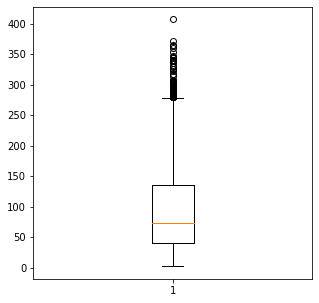

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.pre_clean_len)
plt.show()

From the above box plot, some of tweets are way more than 140 characters long.

In [7]:
df[df.pre_clean_len > 140].head(10)

,text,label,pre_clean_len
0,Cinta itu adalah jiwa. Antara cinta sejati ...,0,285
1,Selalu salut sama @emakblogersolo yg gak henti...,0,284
2,Ternyata film_okb Mengandung Kisah Nyata Penul...,0,282
3,Boleh Miskin Asal Bahagia. \rAsal tau aja cara...,0,293
4,"Janganlah engkau MENGARUNGI LAUTAN, percuma de...",0,283
5,Sudahkah Anda memiliki tabungan di Akhirat ?? ...,0,277
12,"Segelas Beras untuk Berdua\r""Untuk kami berdua...",0,276
13,"George Orwell, Bagaimana Si Miskin Mati, esai,...",0,277
14,Pergi krn tugas pulang karena beras @ JW Marri...,0,161
15,"_Hidup itu dinikmati_\r\r""hidup itu dinikmati""...",0,283


### Cleaning data

dealing with '@'mention
this information doesn't add value to build sentiment analysis model

In [8]:
df.text[1907]

'Gpp kok asal jangan sampe berdebu...\r\rMbak @lrstdw_  mau ikutan dibahagiain pake gombalan orang miskin atau pantun orang kolong jembatan Gak ?'

In [9]:
import re
re.sub(r'@[A-Za-z0-9]+','', df.text[1907])

'Gpp kok asal jangan sampe berdebu...\r\rMbak _  mau ikutan dibahagiain pake gombalan orang miskin atau pantun orang kolong jembatan Gak ?'

Dealing with URL links
same with @mention, for sentiment analysis purpose, this can be ignored

In [10]:
df.text[0]

'\x8a\x97\x93Cinta itu adalah jiwa. Antara cinta sejati dan jiwa tak dapat dipisahkan, cintapun merdeka sebagaimana jiwa. Ia tidak membedakan di antara derajat dan bangsa, di antara kaya dan miskin,\x8a\x97_ https://www.instagram.com/p/BuGfDr1FKJn/?utm_source=ig_twitter_share&igshid=d9qqr424pl5wÎ¾\x8a\x97_'

In [11]:
re.sub(r"https\S+",'',df.text[0])

'\x8a\x97\x93Cinta itu adalah jiwa. Antara cinta sejati dan jiwa tak dapat dipisahkan, cintapun merdeka sebagaimana jiwa. Ia tidak membedakan di antara derajat dan bangsa, di antara kaya dan miskin,\x8a\x97_ '

Dealing with hashtag / numbers

In [12]:
df.text[485]

'tolong ya kalean semua sadar, bela keluarga kalean dulu. berjuangan buat buat keluarga biar ga ngeluh miskin terus . orang yg kalian bela skrg mungkin lg ena ena dan ketawa. tai #TangkapPRABOWO'

In [13]:
re.sub("[^a-zA-Z]", " ", df.text[485])

'tolong ya kalean semua sadar  bela keluarga kalean dulu  berjuangan buat buat keluarga biar ga ngeluh miskin terus   orang yg kalian bela skrg mungkin lg ena ena dan ketawa  tai  TangkapPRABOWO'

### Defining data cleaning function
With above data cleaning task, we will define data cleaning function and then will be applied to the whole dataset.

In [14]:
from nltk.tokenize import WordPunctTokenizer

tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r"https\S+"
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    stripped = re.sub(combined_pat, '', text)
    letters_only = re.sub("[^a-zA-Z]", " ", stripped)
    lower_case = letters_only.lower()
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

testing = df.text[50:60]

test_result = []
for t in testing:
    test_result.append(tweet_cleaner(t))
test_result

['jauh jauh harga susu bayi harga beras kg aja kayaknya gak ngerti itu orang',
 'dari pengguna twitter instagram facebook menyerukan gerakan menikahlah dan kau akan hidup enak bahagia sentausa yg mana mereka sendiri aja gak tau mumetnya bayar tagihan listrik bayar iuran sampah lingkungan jatah beli beras stok sabun cuci belum lagi dadakan loro',
 'pk tepung beras rosbren ya',
 'ketika diskon lebaran dan isi dompet tidak sehati berasa orang paling miskin dimuka bumi',
 'buka puasa pake beras kencur enak jugak ya',
 'berorganisasi membuatku bertambah miskin',
 'sekarang banyak insan yang resah untuk melangkah di ladang sendiri tidak lain di karenakan premanism juga segolongan yang selalu mementingkan diri sendiri sangat ironis sekali sungguh miskin moral di tanah beribu budaya',
 'sudah mulai kelihatan diskonan hari raya tp maaf ngga tergoda gw gimana mau tergoda sadar miskin duluan gw anj gamampu beli',
 'operasi kelamin pake beras trans gendar',
 'aduh gamau aku pake white pants aku mi

In [15]:
for t in df.text:
    df.loc[(df.text == t), 'text'] = tweet_cleaner(str(t))

### Saving Cleaned data as csv


In [16]:
# TO-DO change the filename
df.drop('pre_clean_len', axis=1).to_csv('clean_beras_or_miskin.csv', encoding='utf-8', index=False)
clean_df = pd.read_csv('clean_beras_or_miskin.csv')
clean_df.head()

,text,label
0,cinta itu adalah jiwa antara cinta sejati dan ...,0
1,selalu salut sama yg gak henti nya memfasilita...,0
2,ternyata film okb mengandung kisah nyata penul...,0
3,boleh miskin asal bahagia asal tau aja caranya...,0
4,janganlah engkau mengarungi lautan percuma deh...,0


## Data pre-processing
The first step when building a neural network model is getting your data into the proper form to feed into the network. Since we're using embedding layers, we'll need to encode each word with an integer.

First, let remove all punctuation. Then get all the text without newlines and split it into individual words

In [17]:
from string import punctuation
all_text = '\n'.join([c for c in clean_df.text.map(str) if c not in punctuation])

#split by new lines and spaces
tweets_split = all_text.split('\n')
all_text = ' '.join(tweets_split)

# create a list of words
words = all_text.split()


In [18]:
print(len(tweets_split))
print(all_text[:100])
print(len(words))

3207
cinta itu adalah jiwa antara cinta sejati dan jiwa tak dapat dipisahkan cintapun merdeka sebagaimana
46233


### Encoding the words
The embedding lookup requires that we pass in integers to out network. The easiest way to do this is to create dictionaries that map the words in the vocabulary to integers. Then we can convert each of our tweets into integers so they can be passed into the network.

In [19]:
from collections import Counter

#build dictionary that maps words to integers
counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

# use the dict to tokenize each tweets in tweets_split
## store the tokenized tweets in tweets_ints
tweets_ints = []
for tweet in tweets_split:
    tweets_ints.append([vocab_to_int[word] for word in tweet.split()])


print out the number of unique words in our vocabulary and the contents of the first, tokenized review.

In [20]:
# stats about vocabulary
print('Unique words: ', len((vocab_to_int)))
print()

# print tokens in first review
print("Tokenized review: \n", tweets_ints[:1])

Unique words:  10057

Tokenized review: 
 [[298, 11, 66, 123, 436, 298, 2412, 7, 123, 54, 376, 3827, 3828, 1769, 3829, 123, 569, 33, 1424, 4, 436, 2413, 7, 1179, 4, 436, 9, 7, 1]]


### Removing Outliers
As an additional pre-processing step, we want to make sure taht our reviews are in good shape for standard processing. That is, our network will expect a standard input text size, and so, we'll want to shape our tweets into a specific length. We'll approach this task in two main steps:

1. Getting rid of extremely long or short tweets; the outliers
2. Padding/truncating the remaining data so that we have reviews of the same length.

Before we pad our tweets text, we should check for tweets of extremely short or long lengths; outliers that may mess with our training.

In [21]:
# outlier tweets stats
tweets_lens = Counter([len(x) for x in tweets_ints])
print("Zero-length tweets: {}".format(tweets_lens[0]))
print("Maximum tweets length: {}".format(max(tweets_lens)))

Zero-length tweets: 0
Maximum tweets length: 67


We don't have tweets with zero length

### Padding sequences
To deal with short and very long tweets, we'll pad or truncate all our tweets to a specific length. For tweets shorter than some `seq_length`, we'll pad with 0s. For tweets longer than `seq_length`, we can truncate them to the first `seq_length` words.

In [22]:
def pad_features(tweets_ints, seq_length):
    '''return features of tweets_ints, where each tweets
    is padded with 0's or truncated to the input seq_length
    '''
    # getting the correct rows x cols shape
    features = np.zeros((len(tweets_ints), seq_length), dtype=int)
    
    for i, row in enumerate(tweets_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features    

In [49]:
seq_length= 140

features = pad_features(tweets_ints, seq_length=seq_length)

## Test Statement ##
assert len(features)==len(tweets_ints), "Your features should have as many rows as tweets."
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."

print(features[1])



[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0  134 3830   29    6   30 3831   47 2414  783    1  494
  703 3832  146   64   13 1770 2415  626  570    4 3833   35   22 1771]


## Training, validation, Test
With our data in nice shape, we'll split it into training, validation and test sets.

In [50]:
split_frac = 0.8

## split data into training, validation, and test data
## (features and labels, x and y)

split_idx = int(len(features)*split_frac)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = clean_df.label[:split_idx], clean_df.label[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(2565, 140) 
Validation set: 	(321, 140) 
Test set: 		(321, 140)


## Data Loaders and Batching
After creating training, test and validation data, we can create DataLoaders for this data
1. Create a known format for accessing our data, using TensorDataset which takes in an input set of data and a target set of data with the same first dimension, and creates a dataset.
2. Create DataLoaders and batch our training, validation, and test Tensor adtasets.


In [51]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(np.array(train_x)), torch.from_numpy(np.array(train_y)))
valid_data = TensorDataset(torch.from_numpy(np.array(val_x)), torch.from_numpy(np.array(val_y)))
test_data = TensorDataset(torch.from_numpy(np.array(test_x)), torch.from_numpy(np.array(test_y)))

# dataloaders
batch_size = 50

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [46]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 200])
Sample input: 
 tensor([[   0,    0,    0,  ...,   96, 7265,    1],
        [   0,    0,    0,  ...,    1,   17,  860],
        [   0,    0,    0,  ...,    5,   17,  423],
        ...,
        [   0,    0,    0,  ...,    0,  729,    2],
        [   0,    0,    0,  ...,   12,    5, 6763],
        [   0,    0,    0,  ...,    1,  151, 2298]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0])


---
# Sentiment Network with PyTorch

Below is where we'll define the network.

<img src="assets/img2.png" width=50%>

The layers are as follows:
1. An [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) that converts our word tokens (integers) into embeddings of a specific size.
2. An [LSTM layer](https://pytorch.org/docs/stable/nn.html#lstm) defined by a hidden_state size and number of layers
3. A fully-connected output layer that maps the LSTM layer outputs to a desired output_size
4. A sigmoid activation layer which turns all outputs into a value 0-1; return **only the last sigmoid output** as the output of this network.

### The Embedding Layer
We need to add an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) because there are 10000+ words in our vocabulary. It is massively inefficient to one-hot encode that many classes. So, instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table. You could train an embedding layer using Word2Vec, then load it here. But, it's fine to just make a new layer, using it for only dimensionality reduction, and let the network learn the weights.

### The LSTM Layer(s)

We'll create an [LSTM](https://pytorch.org/docs/stable/nn.html#lstm) to use in our recurrent network, which takes in an input_size, a hidden_dim, a number of layers, a dropout probability (for dropout between multiple layers), and a batch_first parameter.

Most of the time, you're network will have better performance with more layers; between 2-3. Adding more layers allows the network to learn really complex relationships. 


In [52]:
import torch.nn as nn

class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden
        

## Instantiate the network

Here, we'll instantiate the network. First up, defining the hyperparameters.

* `vocab_size`: Size of our vocabulary or the range of values for our input, word tokens.
* `output_size`: Size of our desired output; the number of class scores we want to output (pos/neg).
* `embedding_dim`: Number of columns in the embedding lookup table; size of our embeddings.
* `hidden_dim`: Number of units in the hidden layers of our LSTM cells. Usually larger is better performance wise. Common values are 128, 256, 512, etc.
* `n_layers`: Number of LSTM layers in the network. Typically between 1-3

In [53]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int) + 1 # +1 for the 0 padding + our word tokens
output_size = 1
embedding_dim = 100
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embedding): Embedding(10058, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


## Training
* `lr`: Learning rate for our optimizer.
* `epochs`: Number of times to iterate through the training dataset.
* `clip`: The maximum gradient value to clip at (to prevent exploding gradients).

In [54]:
lr = 0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [56]:
# training params

epochs = 4 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 10
clip=5 # gradient clipping

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1
        
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:
                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/4... Step: 10... Loss: 0.682606... Val Loss: 1.308280
Epoch: 1/4... Step: 20... Loss: 0.537052... Val Loss: 1.253924
Epoch: 1/4... Step: 30... Loss: 0.494214... Val Loss: 1.193625
Epoch: 1/4... Step: 40... Loss: 0.570617... Val Loss: 1.182104
Epoch: 1/4... Step: 50... Loss: 0.515990... Val Loss: 1.338417
Epoch: 2/4... Step: 60... Loss: 0.427719... Val Loss: 1.435523
Epoch: 2/4... Step: 70... Loss: 0.407219... Val Loss: 1.131366
Epoch: 2/4... Step: 80... Loss: 0.456682... Val Loss: 1.341394
Epoch: 2/4... Step: 90... Loss: 0.587985... Val Loss: 1.421694
Epoch: 2/4... Step: 100... Loss: 0.570724... Val Loss: 1.385773
Epoch: 3/4... Step: 110... Loss: 0.363232... Val Loss: 1.366840
Epoch: 3/4... Step: 120... Loss: 0.588041... Val Loss: 1.358652
Epoch: 3/4... Step: 130... Loss: 0.294500... Val Loss: 1.925881
Epoch: 3/4... Step: 140... Loss: 0.328632... Val Loss: 1.562441
Epoch: 3/4... Step: 150... Loss: 0.428853... Val Loss: 1.777950
Epoch: 4/4... Step: 160... Loss: 0.142172... Val 

---
## Testing

There are a few ways to test your network.
- **Test data performance :** First, we'll see how our trained model performs on all our defined test_data, above. We'll calculate the average loss and accuracy over the test data.
- **Inference on user-generated data:** Second, We'll see if we can input just one example review at a time (without a label), and see what the trained model predicts.

In [59]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 2.179
Test accuracy: 0.268
